# Required Packages

In [1]:
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.integrate import solve_ivp
from scipy.stats import gamma, norm

# MCMC Setup

## **SIRD Model IVP Solution**
Ivp solution to the SIRD model with Delhi used as reference

### Solving IVP

In [2]:
#constants
prng = np.random.default_rng()
sqrt_two_pi = math.sqrt(2.0*math.pi)

In [3]:
N = 10000
tmax=110

def sird_model(t, z, beta, gamma, kappa):
    """Numpy array of SIRD model

    Args:
        t (float): time
        z (array): initial conditions for S(0), I(0), R(0), D(0)
        beta (float): infection rate parameter
        gamma (float): recovery rate parameter
        kappa (float): mortality rate parameter

    Returns:
        numpy array : numpy array with dSdt, dIdt, dRdt, dDdt
    """

    s, i, r, d = z

    dSdt = - (beta * s * i) / N
    dIdt =   (beta * s * i) / N - (gamma * i) - (kappa * i)
    dRdt = gamma*i
    dDdt = kappa*i

    return np.array([dSdt, dIdt, dRdt, dDdt])

#initial conditions
i0 = 3
z0 = np.array([N - i0, i0, 0, 0])

#parameters
beta_0, gamma_0, kappa_0 = 0.2070, 0.0505, 0.0155

#time series
t_ser = np.linspace(0, tmax, tmax+1)

#soln
soln = solve_ivp(sird_model, [0, tmax], z0, t_eval=np.linspace(0, tmax, tmax+1)
                 , args=[beta_0, gamma_0, kappa_0])
Sy, Iy, Ry, Dy = soln.y

### Dataframes for CSV files

In [4]:
#convert to dataframe (melt used for seaborn purposes)
stack = np.column_stack((soln.t, Sy, Iy, Ry, Dy))

dfSIRD = pd.DataFrame(data=stack)
dfSIRD.rename(columns={0: 't', 1 : 'S', 2 : 'I', 3 : 'R', 4 : 'D'}, inplace=True)
dfSIRD_melt = pd.melt(dfSIRD, id_vars='t', value_vars=['S', 'I', 'R', 'D'])

#observed infections
case_data = pd.read_csv(r'case_data.csv', delim_whitespace=True)
case_data_melt = pd.melt(case_data, id_vars='t', value_vars='I(t)')

#observed infections, recoveries, and deaths from 51-110
test_predictions = pd.read_csv(r'test_predictions.csv', delim_whitespace=True)
test_predictions_melt = pd.melt(test_predictions, id_vars='t')

prior_data = pd.read_csv(r'prior_data_worldwide.csv')
prior_data_melt = pd.melt(prior_data, id_vars='Location')
#summary statistics
prior_data_stats = prior_data.describe()

### SIRD Solution Plotted Against Case Data and Test Predictions

General check to see how solution does against case data.
Another check to see how close this initial guess is to the test predictions.

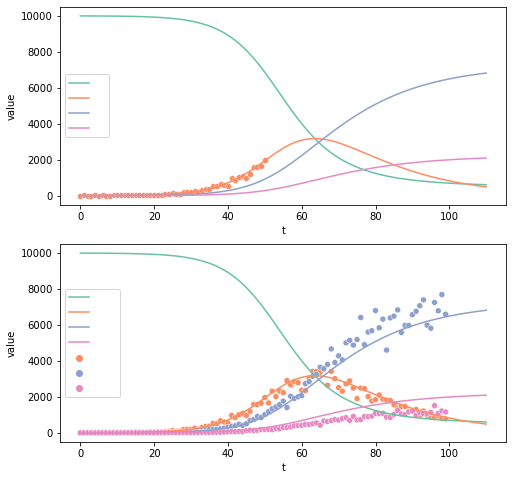

In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
palette = sns.color_palette('Set2')
sns.set_style({'ax.edgecolor' : 'white'})

# with sns.axes_style(rc={
#     'ytick.labelcolor' : 'white', 
#     'xtick.labelcolor' : 'white', 
#     'axes.facecolor' : '#37474f', 
#     'figure.facecolor' : '#37474f', 
#     'axes.labelcolor' : 'white', 
#     'grid.color' : '#37474f'
#     }):
sns.lineplot(data=dfSIRD_melt, x='t', y='value', hue='variable', palette=palette[0:4], ax=ax1)
sns.scatterplot(data=case_data_melt, x='t', y='value', color=palette[1], ax=ax1)
# with sns.axes_style(rc={
#     'ytick.labelcolor' : 'white', 
#     'xtick.labelcolor' : 'white', 
#     'axes.facecolor' : '#37474f', 
#     'figure.facecolor' : '#37474f', 
#     'axes.labelcolor' : 'white', 
#     'grid.color' : '#37474f'
#     }):
sns.lineplot(data=dfSIRD_melt, x='t', y='value', hue='variable', palette=palette[0:4], ax=ax2)
sns.scatterplot(data=test_predictions_melt, x='t', y='value', hue='variable', palette=palette[1:4], ax=ax2)

legend = ax1.legend(loc='center left', title='')
legend2 = ax2.legend(loc='center left', title='')
for text in legend.get_texts():
    text.set_color('white')
for text2 in legend2.get_texts():
    text2.set_color('white')
#plt.savefig('solution_plot.png', dpi=300)

## **Defining Functions**

In [7]:
#dataframe concatenating soln and observation for comparison purposes
I_obs_soln = pd.concat([case_data.iloc[:, 1], pd.DataFrame(Iy[:51], columns=['Iy(t)'])], axis=1)
#print(I_obs_soln.values)
I_obs_soln.head()

,I(t),Iy(t)
0,2.0,3.000000
1,9.0,3.454036
2,3.0,3.976780
3,3.0,4.578487
4,9.0,5.271080


In [8]:
#How do you determine the bounds?
beta_0, gamma_0, kappa_0 = prior_data_stats.loc['min'] - 3*prior_data_stats.loc['std']
beta_f, gamma_f, kappa_f = prior_data_stats.loc['max'] + 3*prior_data_stats .loc['std']
phi_0, phi_f = 0, 0.05

bounds_p =[(beta_0, beta_f),(gamma_0, gamma_f),(kappa_0, kappa_f),(phi_0, phi_f)]

disp = np.array([0.02,0.01,0.005,0.005])

### **Bayesian Inference Functions**

In [9]:
def get_binom(y, mu, phi):
    """generate negative binomial with parameter mu and phi

    Args:
        y (float): observation y
        mu (float): mean
        phi (float): over disperion parameter

    Returns:
        float: negative binomial pmf of y
    """
    r = 1/phi
    p1 = math.lgamma(y+r) - math.lgamma(y+1) - math.lgamma(r)
    t1 = r * np.log(r / (r + mu))
    t2 = y * np.log(mu / (r + mu))
    res = p1 + t1 + t2   
    return np.exp(res)

In [10]:
#total likelihood calculation
def get_likelihood_val(u) :
    beta, gamma, kappa, phi = u 
    """
    gets total likelihood of all 50 daily probabilities by finding 
    cumulative product of likelihoods for individual probabilities

    Returns:
        float: total likelihood of the particular parameters beta, gamma, kappa, phi
    """
    
    tmax = 50
    t_ser = np.linspace(0,tmax,tmax+1)
    sol = solve_ivp( sird_model, [0, tmax], z0, args=(beta, gamma, kappa), t_eval = t_ser)
    i_of_t = sol.y[1,:];
    #solved Eqns 1 to get i(t)
    total_like = 1
   
    for y, I in zip(I_obs_soln.values[:,0], i_of_t ):
        total_like *= get_binom(y, I, phi)

    return total_like

In [11]:
def get_prior (u):
    return rv_gamma.pdf(u[0])* rv_beta.pdf(u[1])* rv_kappa.pdf(u[2])* rv_phi.pdf(u[3])

In [12]:
def get_posterior(u):
    return get_likelihood_val(u) * get_prior(u) 

def get_pi_val(u):
    return get_likelihood_val(u)*get_prior(u)

### **Monte Carlo Random Walk Functions**

In [13]:
def get_next_pos():
    r1 = (range_p * prng.random(size=4)) + init_val_p   
    return r1

In [14]:
def get_next_pos_rw (u_cur):
    u_new = np.copy(u_cur)
    # Get new position
    displacements = disp*prng.uniform (low = -1, high = 1, size = 4)
    return u_new + displacements

In [15]:
def in_bounds ( u ):
    for i,pos in enumerate(u):
        if (pos<bounds_p[i][0]) or (pos>bounds_p[i][1]):
            return False
    return True

## **Graphing Priors Against Prior Data**

In [16]:
# beta, gamma, kappa chosen using prior data mean and standard deviations
# fitted along normal distribution

rv_beta  = norm(loc=prior_data['beta'].mean(), scale=prior_data['beta'].std())
rv_gamma = norm(loc=prior_data['gamma'].mean(), scale=prior_data['gamma'].std())
rv_kappa = norm(loc=prior_data['Kappa'].mean(), scale =prior_data['Kappa'].std())

rv_phi   = gamma (11, scale = 0.001)

### **Parameter Distributions**

C:\Users\Vivek\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Vivek\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Vivek\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

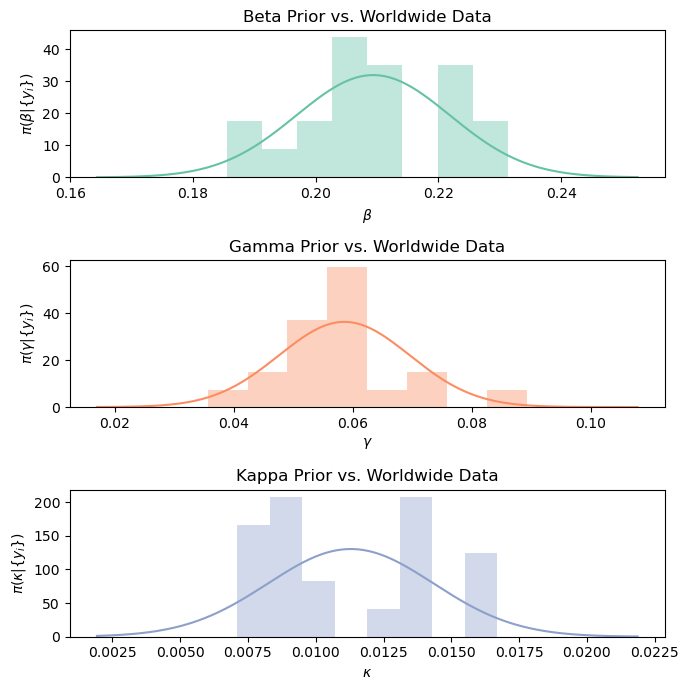

In [17]:
# Create a new figure for beta prior
plt.rcdefaults()
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7,7))
palette = sns.color_palette('Set2')
# Plot calculated beta values from other locations
sns.distplot(prior_data['beta'], color=palette[0], fit=norm, 
            kde=False, fit_kws={'color' : palette[0]}, bins=8, ax=ax1)

# Set axes labels
ax1.set_ylabel(r'$\pi(\beta|\{y_i\})$')
ax1.set_xlabel(r'$\beta$')


ax1.set_title("Beta Prior vs. Worldwide Data")

# Plot calculated gamma values from other locations
sns.distplot(prior_data['gamma'], color=palette[1], fit=norm, kde=False, 
            fit_kws={'color' : palette[1]}, bins=8, ax=ax2)

# Set axes labels
ax2.set_ylabel(r'$\pi(\gamma|\{y_i\})$')
ax2.set_xlabel(r'$\gamma$')


ax2.set_title("Gamma Prior vs. Worldwide Data")

# Plot calculated kappa values from other locations
sns.distplot(prior_data['Kappa'], color=palette[2], fit=norm, kde=False, 
            fit_kws={'color' : palette[2]}, bins=8, ax=ax3)

# Set axes labels
ax3.set_ylabel(r'$\pi(\kappa|\{y_i\})$')
ax3.set_xlabel(r'$\kappa$')

ax3.set_title("Kappa Prior vs. Worldwide Data")

plt.tight_layout()
plt.show()
fig.savefig('priordist_data.png', dpi=300)

# Simulating the MCMC Process

In [20]:
# Simulation parameters
nsteps = 10000 # Number of Monte Carlo steps

# Initial state in parameter space (delhi used for initial guess)
u_cur = np.array([0.2070, 0.0505, 0.0155, 0.01])

# Counters
cnt, acc_cnt = 0, 0

# lists that will hold time series data 
beta_cum, gamma_cum, kappa_cum, phi_cum = [], [], [], []

# Rolling estimate of the parameters
est = np.zeros(4)

## The Main Monte Carlo Loop

The main loop computes an instance of the **Metropolis-Hasting MCMC algorithm** via the following steps:

- Compute the **posterior $\pi(u_{cur})$** of the **current position** $u_{cur}$
- **Propose a move** within ${\rm I\!R}^n$ parameter space $u_{new}. The new state is chosen via a random walk (see Monte Carlo Functions). The random walk method is particularly efficient in high dimensional parameter spaces.
- Compute the **posterior $\pi(u_{new})$** of the **new position $u_{new}$**
- **Determine acceptance probability** and retain if and only if  $$r \hspace{1mm} < \hspace{1mm} \frac{\pi(u_{new})}{\pi(u_{cur})} \hspace{1cm} r \in [0, 1]$$

In [21]:
# Main MC loop
for istep in range(nsteps):

    # Compute pi at current u
    pi_cur = get_posterior(u_cur)

    # Propose a new u
    u_new = get_next_pos_rw(u_cur)
    
    # Compute pi at new u
    pi_new = get_posterior(u_new)
    
    # Compute acceptance factor
    acc_factor = pi_new/pi_cur

    # Ratio of proposal probabilities is 1

    if not in_bounds(u_new):
        # Posterior prob. is 0 at u_new
        acc_factor = 0
    
    # Accept/Reject proposal
    if (prng.random() <= acc_factor):
        # Update position ##
        u_cur = np.copy(u_new)
        # Keep track of number of acceptances
        acc_cnt += 1

    # Time series of parameters
    if (istep % 10 == 0):
        beta_cum.append(u_cur[0])
        gamma_cum.append(u_cur[1])
        kappa_cum.append(u_cur[2])
        phi_cum.append(u_cur[3])
        
    # Compute estimate every 10 steps
    if ((istep > (nsteps)//2) and (istep%10==0)):
        est = est + u_cur
        cnt += 1


## Estimate and Acceptance Ratio

In [22]:
# Compute estimates        
print("Estimate =", est/cnt) 

print("Acceptance ratio ", acc_cnt/nsteps)

Estimate = [0.18982919 0.04751649 0.0029129  0.01553009]
Acceptance ratio  0.0362


## Long Term Behavior of Parameters under MCMC Simulation

### **Summary Statistics of Parameter Estimates**

In [23]:
#generate time series and set dataframe for parameters
t = np.arange(nsteps//10)
parameter_series = pd.DataFrame([t, beta_cum, gamma_cum, kappa_cum, phi_cum]).T
parameter_series.rename(columns={0 : 't', 1 : 'beta', 2 : 'gamma', 3 : 'kappa', 4 : 'phi'}, 
                        inplace=True)
#make seaborn friendly
parameter_series_melt = pd.melt(parameter_series, id_vars='t')

parameter_series.describe().iloc[:, 1:]

,beta,gamma,kappa,phi
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.189243,0.047252,0.002571,0.015412
std,0.007614,0.006999,0.002800,0.002811
min,0.164408,0.024498,-0.002308,0.007688
25%,0.183870,0.042305,0.000327,0.013541
50%,0.189381,0.047424,0.002072,0.015042
75%,0.194566,0.051674,0.004605,0.016969
max,0.213254,0.066079,0.015500,0.025322


### **Graph of Parameters**

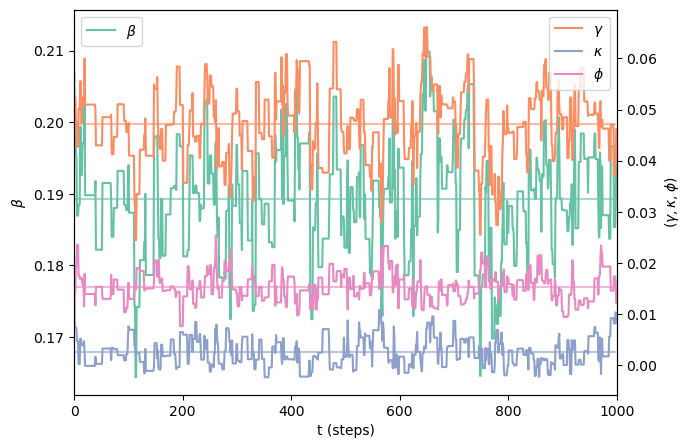

In [24]:
#set new figure with (left & right) y axis
fig, ax = plt.subplots(figsize=(7, 5))
axv = ax.twinx()

#estimate means
parameter_means = parameter_series.describe().loc['mean'][1:]

#plot beta time series
sns.lineplot(data=parameter_series_melt.query('variable == "beta"'), 
            x='t', y='value', color=palette[0], ax=ax)
ax.axhline(y=parameter_means[0], xmin=0, xmax=t.max(), 
            color=palette[0], alpha=0.6)

#plot (gamma, kappa, phi) time series
sns.lineplot(data=parameter_series_melt.query('variable != "beta"'), 
            x='t', y='value', hue='variable', palette=palette[1:4], ax=axv)
axv.hlines(y=parameter_means[1:], xmin=0, xmax=t.max(), color=palette[1:4], alpha=0.6)

#plt.title('Parameters under long MC Simulation')

#set y label
# ax.set_facecolor('#37474f')
# fig.patch.set_facecolor('#37474f')
ax.set_ylabel(r'$\beta$')
axv.set_ylabel(r'($\gamma, \kappa, \phi$)')

#set xlabel
ax.set_xlabel('t (steps)')

#set x limits
plt.xlim([0, len(t)])
# plt.rcParams.update({
#     #'text.color' : 'black',
#     'axes.labelcolor' : 'white', 
#     'xtick.labelcolor' : 'white', 
#     'ytick.labelcolor' : 'white',
#     'axes.titlecolor' : 'white',
#     'axes.edgecolor' : 'white'})
#set legend
ax.legend(loc='upper left', labels=[r'$\beta$']) #bbox_to_anchor=(-0.2, 1),
axv.legend(loc='upper right', #bbox_to_anchor=(1.22, 1), 
        labels=[
            r'$\gamma$', 
            r'$\kappa$', 
            r'$\phi$'])

#fig.savefig('longMCsimul.png', dpi=300)

## 90% Credibility Interval

### **Bounds of Interval**

Computes upper and lower bounds of 90% credibility interval

In [25]:
u_cum = [beta_cum, gamma_cum, kappa_cum, phi_cum]
params = ['beta', 'gamma', 'kappa', 'phi']
for u_i, param in zip(u_cum, params):
    u_i.sort()
    new_interval = u_i[int(.05*len(u_i)):int(.95*len(u_i))]
    
    maxi = new_interval[-1]
    mini = new_interval[0]
    print("Parameter is:", param)
    print(f'Upper Bound is: {maxi}')
    print(f'Lower Bound is: {mini} \n')

Parameter is: beta
Upper Bound is: 0.20170365088314937
Lower Bound is: 0.17705406658039227 

Parameter is: gamma
Upper Bound is: 0.05945703543230885
Lower Bound is: 0.035531877801741524 

Parameter is: kappa
Upper Bound is: 0.007274025063167548
Lower Bound is: -0.0014365907899760609 

Parameter is: phi
Upper Bound is: 0.02039448351183178
Lower Bound is: 0.011175378031568397 



# Posterior Marginals Against Prior Distributions

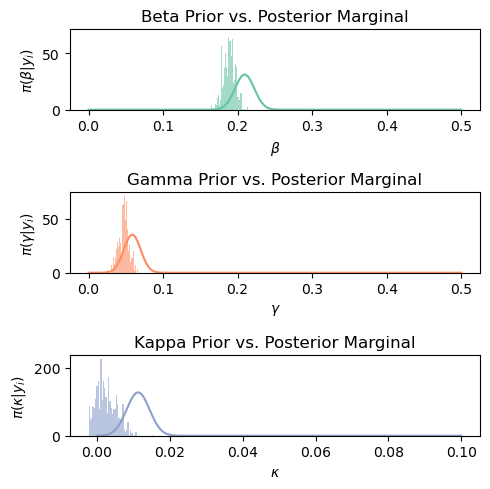

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5,5))

plt.rcdefaults()

# Plot time series data for delta, beta
ax1.hist(beta_cum, color=palette[0], bins=50, density=True, alpha=0.6)


# Set axes labels
ax1.set_ylabel(r'$\pi(\beta | y_i)$')
ax1.set_xlabel(r'$\beta$')

x = np.linspace(0,0.5,200)
beta_prior = norm.pdf(x, loc=prior_data['beta'].mean(), scale=prior_data['beta'].std())
ax1.plot(x, beta_prior, color=palette[0])
ax1.set_title("Beta Prior vs. Posterior Marginal")


ax2.hist(gamma_cum, color = palette[1], bins = 50, density = True, alpha=0.6)

# Set axes labels
ax2.set_ylabel(r'$\pi(\gamma | y_i)$')
ax2.set_xlabel(r'$\gamma$')

gamma_prior = norm.pdf(x, loc=prior_data['gamma'].mean(), scale=prior_data['gamma'].std())
ax2.plot(x, gamma_prior, color=palette[1])
ax2.set_title("Gamma Prior vs. Posterior Marginal")

# Plot time series data for delta, beta
ax3.hist(kappa_cum, color = palette[2], bins = 50, density = True, alpha=0.6)

# Set axes labels
ax3.set_ylabel(r'$\pi(\kappa | y_i)$')
ax3.set_xlabel(r'$\kappa$')

x = np.linspace(0,0.1,200)
kappa_prior = norm.pdf(x, loc=prior_data['Kappa'].mean(), scale=prior_data['Kappa'].std())
ax3.plot(x, kappa_prior, color=palette[2])
ax3.set_title("Kappa Prior vs. Posterior Marginal")

plt.tight_layout()
plt.show()

#fig.savefig('marginals_priors.png', dpi=300)

# Predicting Future Trends and Envelope of Potential Trajectories

## Generating Parameters Samples

In [27]:
#Trim Parameters more to encompass only values in the second half, after equilibrium reached
beta_trim = beta_cum[500:]
gamma_trim = gamma_cum[500:]
kappa_trim = kappa_cum[500:]

#Sample 100 values by taking every 5th value

beta_samp = []
gamma_samp = []
kappa_samp = []

for i in range(500):
    if(i % 5 == 0):
        beta_samp.append(beta_trim[i])
        gamma_samp.append(gamma_trim[i])
        kappa_samp.append(kappa_trim[i])

## Collection of SIRD solutions for Parameter Samples

In [28]:
# Parameters of simulation
N = 10000 # Population
tmax = 110 # No. of days to simulate

# Initial condition
i0 = 3
s0 = N - i0
z0 = np.array([s0, i0, 0, 0])

s_vals = []
i_vals = []
r_vals = []
d_vals = []

for beta, gamma, kappa in zip(beta_samp, gamma_samp, kappa_samp):
    t_ser = np.linspace(0,tmax,tmax+1)
    sol = solve_ivp( sird_model, [0, tmax], z0, args=(beta, gamma, kappa), t_eval = t_ser )
    s_vals.append(sol.y[0,:])
    i_vals.append(sol.y[1,:])
    r_vals.append(sol.y[2,:])
    d_vals.append(sol.y[3,:])
    

## Generating Envelope Bounds

In [29]:
'''
Need to run 110 steps for the 110 days 
For each day, we have 100 values of s, i, r, and d in *_vals arrays
Sum these 100 values and keep track of the minimum and maximum
Divide the daily sums by 100 and return matrix of the daily mean
'''

s_vals_sum = np.zeros(111)
i_vals_sum = np.zeros(111)
r_vals_sum = np.zeros(111)
d_vals_sum = np.zeros(111)

s_vals_min = []
i_vals_min = []
r_vals_min = []
d_vals_min = []

s_vals_max = []
i_vals_max = []
r_vals_max = []
d_vals_max = []

#set min and max as the max and min pop respectively
#this will allow the first update to work regardless of value within sird matrix
min_s, min_i, min_r, min_d = 10000, 10000, 10000, 10000;
max_s, max_i, max_r, max_d = 0, 0, 0, 0;

for j in range(111):
    for x in range(100):
        s_vals_sum[j] += s_vals[x][j]
        if(s_vals[x][j] < min_s):
            min_s = s_vals[x][j]
        if(s_vals[x][j] > max_s):
            max_s = s_vals[x][j]
            
        i_vals_sum[j] += i_vals[x][j]
        if(i_vals[x][j] < min_i):
            min_i = i_vals[x][j]
        if(i_vals[x][j] > max_i):
            max_i = i_vals[x][j]
            
        r_vals_sum[j] += r_vals[x][j]
        if(r_vals[x][j] < min_r):
            min_r = r_vals[x][j]
        if(r_vals[x][j] > max_r):
            max_r = r_vals[x][j]
            
        d_vals_sum[j] += d_vals[x][j]
        if(d_vals[x][j] < min_d):
            min_d = d_vals[x][j]
        if(d_vals[x][j] > max_d):
            max_d = d_vals[x][j]


    s_vals_min.append(min_s)
    min_s = 9999999;  
    s_vals_max.append(max_s)
    max_s = 0;
    
    i_vals_min.append(min_i)
    min_i = 9999999;  
    i_vals_max.append(max_i)
    max_i = 0;
    
    r_vals_min.append(min_r)
    min_r = 9999999;  
    r_vals_max.append(max_r)
    max_r = 0;
    
    d_vals_min.append(min_d)
    min_d = 9999999; 
    d_vals_max.append(max_d)
    max_d = 0;
    
s_vals_mean, i_vals_mean, r_vals_mean, d_vals_mean = [], [], [], [];

for y in range(111):
    s_vals_mean.append(s_vals_sum[y] / 100)
    i_vals_mean.append(i_vals_sum[y] / 100)
    r_vals_mean.append(r_vals_sum[y] / 100)
    d_vals_mean.append(d_vals_sum[y] / 100)

## Future Projection of I, R, D with Envelope

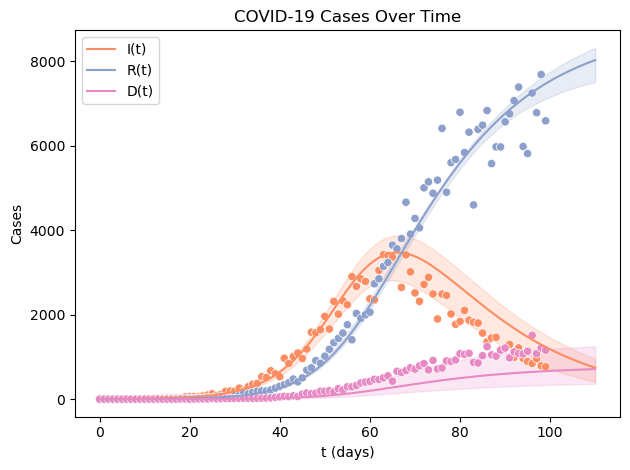

In [30]:
t = np.linspace(0,110, 111)

plt.rcdefaults()

plt.plot(t,i_vals_mean, color=palette[1])
plt.fill_between(t, i_vals_min, i_vals_max, color = palette[1], alpha = 0.2) 

plt.plot(t,r_vals_mean, color = palette[2])
plt.fill_between(t, r_vals_min, r_vals_max, color = palette[2], alpha = 0.2)

plt.plot(t,d_vals_mean,color=palette[3])
plt.fill_between(t, d_vals_min, d_vals_max, color = palette[3], alpha = 0.2)

sns.scatterplot(data=test_predictions_melt, x='t', y='value', hue='variable', 
                palette=palette[1:4])

plt.legend(["I(t)", "R(t)", "D(t)"])

plt.title('COVID-19 Cases Over Time')
plt.xlabel('t (days)')
plt.ylabel('Cases')

plt.tight_layout()

#fig.savefig('future_predictions_envelope_white.png', dpi=300)